# Imports

## Libraries

In [1]:
import random
import os
import time

import cyvlfeat
import matplotlib
import torch
import torchvision

from ipywidgets import *
from IPython.display import display

device = "cpu"

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Import Utility Functions 

Importing from [utils.py](files/utils.py).

In [2]:
from utils import *

## Import Image Processing Functions

Importing from [image_processing.py](files/image_processing.py).

In [3]:
from image_processing import *

# Load Frames

## Load all frames

In [4]:
folders = os.listdir("frames120")
folders = sorted(list(map(lambda folder: os.path.join("frames120", folder), folders)))
triplets_per_folder = {}

for folder in folders:
    triplets_per_folder[folder] = []
    files = sorted(os.listdir(folder), key=lambda file: int(file.split("_")[0]))
    rgb_im_files = list(filter(lambda file: "rgb" in file, files))
    depth_im_files = list(filter(lambda file: "depth.png" in file, files))
    depth_arr_files = list(filter(lambda file: "npy" in file, files))
    num_files = len(rgb_im_files)
    
    for i in range(num_files):
        rgb_im_path = os.path.join(folder, rgb_im_files[i])
        depth_im_path = os.path.join(folder, depth_im_files[i])
        depth_arr_path = os.path.join(folder, depth_arr_files[i])

        rgb_img = cv2.imread(rgb_im_path, cv2.IMREAD_COLOR)     # BGR image
        depth_img = cv2.imread(depth_im_path, cv2.IMREAD_COLOR) # BGR image
        depth_arr = np.load(depth_arr_path)
        
        triplets_per_folder[folder].append((rgb_img, depth_img, depth_arr))
    
print("Number of folders:", len(triplets_per_folder))
for i, k in enumerate(folders):
    print("{}) Loaded {} frames from {}".format(i, len(triplets_per_folder[k]), k))

Number of folders: 1
0) Loaded 120 frames from frames120/20201112_140127


## Pick one frame

Fetching frame: 120 from folder: frames120/20201112_140127


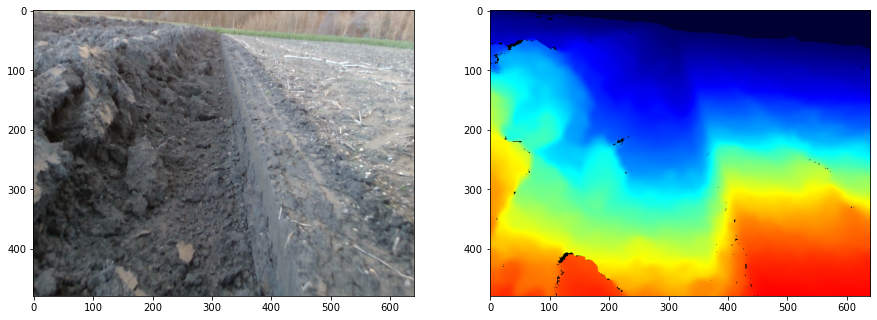

In [5]:
# folder_indices = list(range(8))
# folder_idx = str(random.choice(folder_indices))
# print("Folder choice:", folder_idx)
folder_idx = 0
folder = folders[folder_idx]

# file_indices = list(range(1, 16))
# frame_idx = str(random.choice(file_indices))
# print("Frame choice:", frame_idx)
frame_idx = 119

print("Fetching frame: {} from folder: {}".format(frame_idx+1, folder))
rgb_img, depth_img, depth_arr = triplets_per_folder[folder][frame_idx]

show_image_pairs(rgb_img, depth_img)

# frame: 13 from folder: frames/20201112_133434 (3) -> "Grayscale", "Sobel Vertical", "Threshold", "Hough Line"
# frame: 13 from folder: frames/20201112_140127 (6) -> "Grayscale", "Sobel Vertical", "Spatial Threshold", "Threshold", "Hough Line"

# Create UI Elements

## Define UI Callback Functions

Register a callback for configuration of image processing methods here if needed.

In [6]:
def threshold_config(thresh=127, maxval=255, type=0):
    return {"thresh": thresh, "maxval": maxval, "type": type}

def adaptive_threshold_config(maxValue, adaptiveMethod, thresholdType, blockSize, C):
    return {"maxValue": maxValue, "adaptiveMethod": adaptiveMethod, "thresholdType": thresholdType, "blockSize": blockSize, "C": C}

def spatial_threshold_config(min_x=0, max_x=640, min_y=0, max_y=480):
    return {"range_x": (min_x, max_x), "range_y": (min_y, max_y)}

def avg_blur_config(ksize):
    return {"ksize": ksize}

def median_blur_config(ksize):
    return {"ksize": ksize}

def bilateral_filter_config(d, sigmaColor, sigmaSpace):
    return {"d": d, "sigmaColor": sigmaColor, "sigmaSpace": sigmaSpace}

def gaussian_blur_config(ksize=5, sigmaX=10):
    return {"ksize": (ksize, ksize), "sigmaX": sigmaX}

def laplacian_config(ksize):
    return {"ksize": ksize}
    
def sobelv_config(ksize=5):
    return {"ksize": ksize}
    
def sobelh_config(ksize=5):
    return {"ksize": ksize}

def canny_config(threshold1=50, threshold2=100):
    return {"threshold1": threshold1, "threshold2": threshold2}

def hough_line_config(average=True,
                      adaptive_thresh=True,
                      num_lines=5,    # take num_lines top voted lines
                      threshold=200,  # minimum votes required to accept a line
                      min_theta=0,    # minimum angles to accept a line
                      max_theta=180,  # maximum angles to accept a line
                      resolution=1,   # resolution: 2 == unit angle: 0.5
                      min_distance=9, # take lines separated with at least min_distance pixels
                      min_angle=10):  # take lines separated with at least min_angle degrees
    return {"average": average,
            "adaptive_thresh": adaptive_thresh,
            "num_lines": num_lines,
            "threshold": threshold,
            "min_theta": min_theta,
            "max_theta": max_theta,
            "resolution": resolution,   
            "min_distance": min_distance,
            "min_angle": min_angle}

## Define Name-UI Mappings

Bind names to the UI elements. Define new UI elements and name-UI element mappings here if needed.

In [7]:
# Defining UI elements for configurations
threshold_ui = lambda: interactive(threshold_config, thresh=(0,255), maxval=(0,255), 
                           type={"Binary": cv2.THRESH_BINARY,
                                 "Binary Inverted": cv2.THRESH_BINARY_INV,
                                 "Trunctate": cv2.THRESH_TRUNC,
                                 "To Zero": cv2.THRESH_TOZERO,
                                 "To Zero Inverted": cv2.THRESH_TOZERO_INV})
adaptive_threshold_ui = lambda: interactive(adaptive_threshold_config, 
                                       maxValue=(0,255), 
                                       adaptiveMethod={
                                           'Adaptive Gaussian Thresholding': cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                           'Adaptive Mean Thresholding': cv2.ADAPTIVE_THRESH_MEAN_C},
                                       thresholdType={"Binary": cv2.THRESH_BINARY,
                                                      "Binary Inverted": cv2.THRESH_BINARY_INV,
                                                      "Trunctate": cv2.THRESH_TRUNC,
                                                      "To Zero": cv2.THRESH_TOZERO,
                                                      "To Zero Inverted": cv2.THRESH_TOZERO_INV},
                                       blockSize=(0,20),
                                       C=(0,20))
spatial_threshold_ui = lambda: interactive(spatial_threshold_config, 
                                           min_x=(0,1000), max_x=(0,1000),
                                           min_y=(0,1000), max_y=(0,1000))
avg_blur_ui = lambda: interactive(avg_blur_config, ksize=(1,20))
median_blur_ui = lambda: interactive(median_blur_config, ksize=(1,20))
bilateral_filter_ui = lambda: interactive(bilateral_filter_config, d=(1,20), sigmaColor=(1,100), sigmaSpace=(1,100))
gaussian_blur_ui = lambda: interactive(gaussian_blur_config, ksize=(1,20), sigmaX=(1,20))
laplacian_ui = lambda: interactive(laplacian_config, ksize=(1,20))
sobelv_ui = lambda: interactive(sobelv_config, ksize=(1,20))
sobelh_ui = lambda: interactive(sobelh_config, ksize=(1,20))
canny_ui = lambda: interactive(canny_config, threshold1=(0,100), threshold2=(0,100))
hough_line_ui = lambda: interactive(hough_line_config,
                                    num_lines=(1,500),
                                    threshold=(0,100000),
                                    min_theta=(0,180),
                                    max_theta=(0,180),
                                    resolution=(1,5),
                                    min_distance=(0,1000),
                                    min_angle=(0,180))

# Binding names to the configuration UI elements
preproc_ui = {
    "Grayscale": None,
    "Contrast": None,
    "ROI Threshold": None,
    "Threshold": threshold_ui,
    "Adaptive Threshold": adaptive_threshold_ui,
    "Spatial Threshold": spatial_threshold_ui,
    "Average Blur": avg_blur_ui,
    "Median Blur": median_blur_ui,
    "Bilateral Filter": bilateral_filter_ui,
    "Gaussian Blur": gaussian_blur_ui,
    "Laplacian": laplacian_ui,
    "Sobel Vertical": sobelv_ui,
    "Sobel Horizontal": sobelh_ui,
}

detect_ui = {
    "Canny Edges": canny_ui,
    "Contour": None,
    "Hough Line": hough_line_ui,
}

ui_elements = {**preproc_ui, **detect_ui}

# Create New Experiment

## Select Methods 

In [8]:
style = {
    'description_width': 'initial'
}

func_stack = []
add_buttons = []
log = Output(layout={'margin': '0px 50px 0px 50px', 'width': "200px"})

for item in ui_elements:
    button = Button(
        description=item,
        disabled=False,
        button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    )
    button.on_click(lambda e: push(func_stack, log, e))
    add_buttons.append(button)

pop_button = Button(
    description="Pop",
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
)
pop_button.on_click(lambda _: pop(func_stack, log))
    
menu1 = HBox([VBox(add_buttons), log, pop_button])

display(menu1)

## Configure Selected Methods

In [9]:
ui_instances = []
for i, k in enumerate(func_stack):
    if ui_elements[k]:
        print("{} {}:".format(i, k))
        ui_instance = ui_elements[k]()
        display(ui_instance)
        ui_instances.append(ui_instance)
    else:
        ui_instances.append(None)

2 Sobel Vertical:


interactive(children=(IntSlider(value=5, description='ksize', max=20, min=1), Output()), _dom_classes=('widget…

4 Hough Line:


interactive(children=(Checkbox(value=True, description='average'), Checkbox(value=True, description='adaptive_…

## Apply Configured Methods

In [10]:
input_image = depth_img.copy() # rgb_img
roi_config = {}
NUM_CORNERS = 5

idx = -1
try:
    idx = func_stack.index("ROI Threshold")
except Exception:
    print("[Info]: ROI Threshold is not selected.")

if idx >= 0:
    matplotlib.use("Qt5Agg")
    roi_config["roi_corners"] = set_roi(input_image, NUM_CORNERS)
    print("[Info]: ROI Threshold is configured.")
    %matplotlib inline

[Info]: ROI Threshold is configured.


In [ ]:
pprint(roi_config)

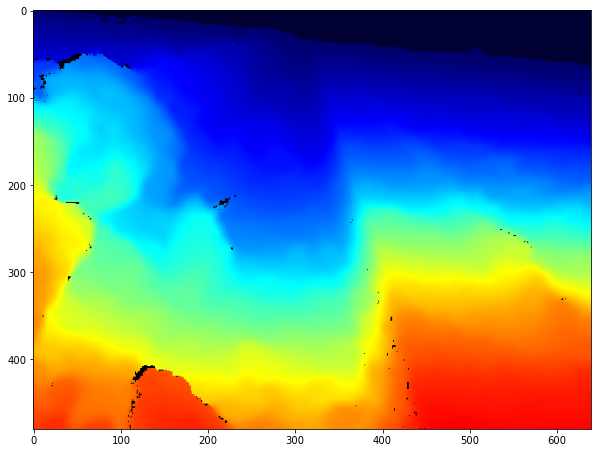

Converting to grayscale


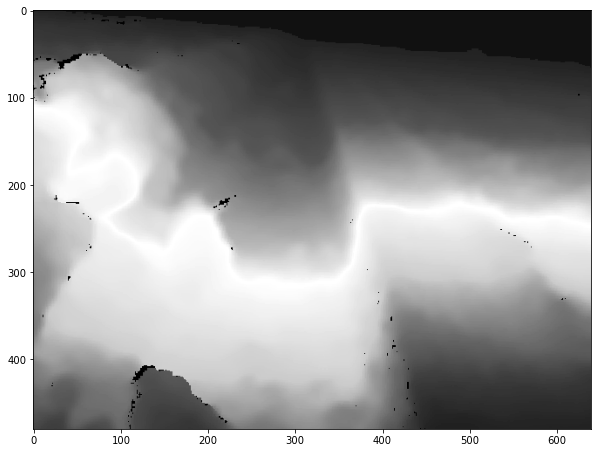

Enhancing contrast


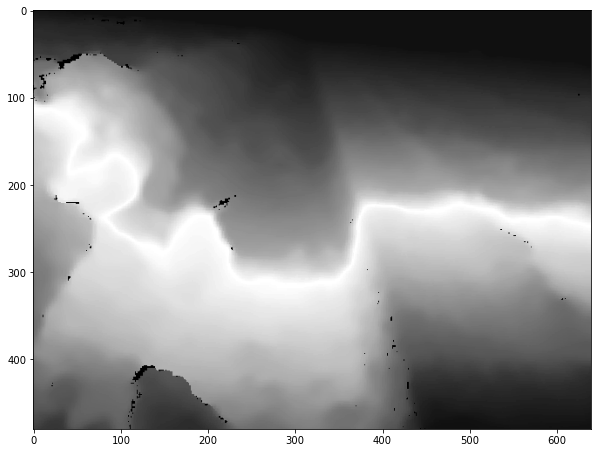

Applying Sobel filter for vertical edges (along y-axis) with args: {'ksize': 5}


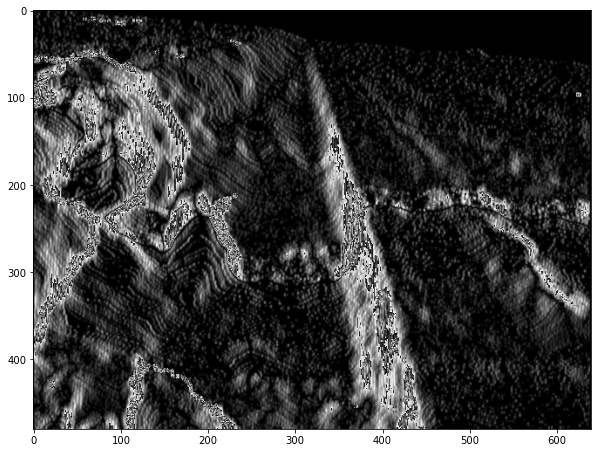

Applying ROI threshold with args: {'roi_corners': array([[292,  48],
       [320,  46],
       [479, 470],
       [376, 463],
       [347, 293]], dtype=int32)}


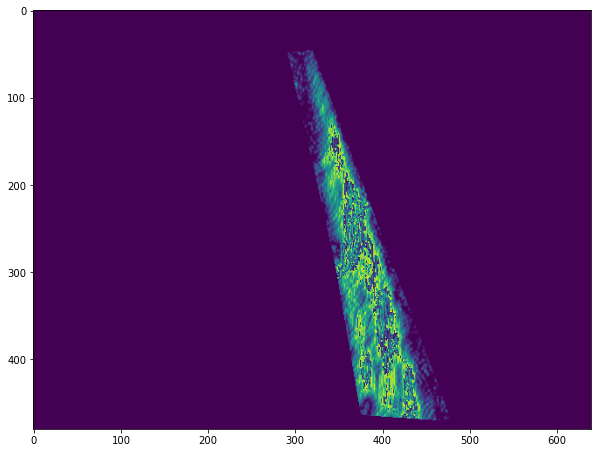

Applying Hough line with args: {'average': True, 'adaptive_thresh': True, 'num_lines': 5, 'threshold': 200, 'min_theta': 0, 'max_theta': 180, 'resolution': 1, 'min_distance': 9, 'min_angle': 10}
[Info]: Max vote is 449
[Info]: Visualizing Hough space.


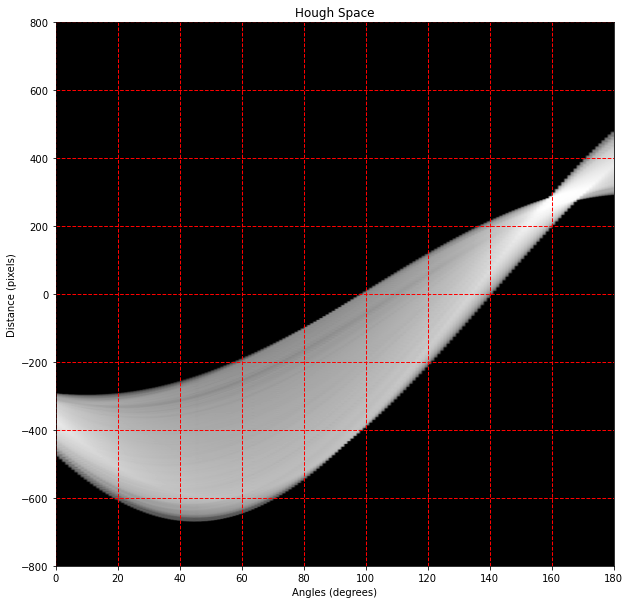

[Info]: 4 lines detected. Showing results for (4/4):
- Line 1, vote: 449.0, rho: -271.6697936210131, theta: 159.88826815642457
- Line 2, vote: 447.0, rho: -252.6579111944966, theta: 157.87709497206703
- Line 3, vote: 270.0, rho: 376.7354596622888, theta: 0.0
- Line 4, vote: 248.0, rho: -142.5891181988743, theta: 146.81564245810054
[Info]: Averaging results to obtain a single line.
- Averaged line, vote: 353.5, rho: -72.5453408380238, theta: 116.14525139664805


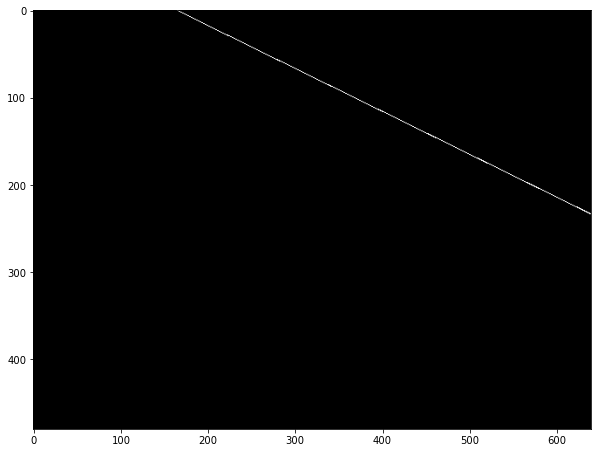

In [11]:
config_stack = []
# Update internal state
for ui_instance in ui_instances:
    config = {}
    if ui_instance:
        config = ui_instance.result
    config_stack.append(config)
if roi_config:
    config_stack[idx] = roi_config

input_image = depth_img.copy() # rgb_img
output = apply_functions(input_image.copy(), func_stack, config_stack)
# show_shapes(input_image.copy(), output, shapeIdx=0, cmap=None)

In [ ]:
contours = find_contours(output, 0.8)
plt.figure(figsize=(10,10))
plt.imshow(output)
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)

plt.show()

convex_hull = convex_hull_image(output)
show_image(convex_hull, cmap="gray")

# TODO: Ideas:
# Take rightmost point
# Clustering with some radius
# Convex hull
# Contours
# Line search over horizontal contours

## Store Current Experiment

In [ ]:
text = Text(
    value='exp.json',
    placeholder='Enter a filename',
    description='Filename:',
    disabled=False
)


button = Button(
    description='Store',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
)

mini_form = HBox([text, button])

button.on_click(lambda _: save_config(text.value, func_stack, config_stack))

display(mini_form)

# Load Previous Experiment from File

In [ ]:
# TODO: Ability to continue with loaded experiment
config_stack = []
uploader_ui = FileUpload(
    accept='.json', # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # True to accept multiple files upload else False
)

uploader_ui.observe(lambda _: load_config(*uploader_ui.data, func_stack, config_stack), names='_counter')

display(uploader_ui)

In [ ]:
exps = []

def load_exp(json_contents, exps):
    for json_content in json_contents:
        exp = json.loads(json_content)
        exps.append((exp["func_stack"], exp["config_stack"]))
    

uploader_ui = FileUpload(
    accept='.json', # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=True  # True to accept multiple files upload else False
)

uploader_ui.observe(lambda _: load_exp(uploader_ui.data, exps), names='_counter')

display(uploader_ui)

In [ ]:
input_image = depth_img # rgb_img
results = []

for exp in exps:
    result = apply_functions(input_image, *exp)
    results.append(result)

In [ ]:
show_shapes(input_image, results[0], shapeIdx=0, cmap=None)

In [ ]:
show_shapes(rgb_img.copy(), results[0], shapeIdx=0, cmap=None)

In [ ]:
# Merging Canny detector result with Hough line detector result
horizontal = results[0]
vertical = convert_coord2mask(horizontal.shape, results[1][0])
merged = horizontal | vertical
show_image(merged, cmap="gray")

# Aside: Experimental

In [ ]:
image = np.zeros((200, 200), dtype=np.uint8)
idx = np.arange(25, 175)
image[idx[::-1], idx] = 255
image[idx, idx] = 255
# image[100, idx] = 255
# image[idx, 100] = 255
show_image(image)

# line_pixels1 = apply_hough_line(image, average=False, min_theta=np.deg2rad(0), max_theta=np.deg2rad(180), threshold=10)
line_pixels = apply_hough_line(image,
                               average=False,
                               num_lines=np.inf,
                               threshold=None,
                               min_theta=-90,
                               max_theta=90,
                               resolution=2,
                               min_distance=9,
                               min_angle=10)
show_shapes(np.zeros((200, 200), dtype=np.uint8), line_pixels)

In [ ]:
image = np.zeros((200, 200), dtype=np.uint8)
idx = np.arange(25, 175)
image[idx[::-1], idx] = 255
image[idx, idx] = 255
# image[100, idx] = 255
# image[idx, 100] = 255
show_image(image)

# Set a precision of 0.5 degree.
# tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
tested_angles = np.linspace(np.deg2rad(-90), np.deg2rad(90), 360)
h, theta, d = hough_line(image, theta=tested_angles)

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(image, cmap="gray")
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(np.log(1 + h).transpose(),
             extent=[d[-1], d[0], np.rad2deg(theta[-1]), np.rad2deg(theta[0])],
             cmap="gray", aspect='auto')
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('auto')

ax[2].imshow(image, cmap="gray")
origin = np.array((0, image.shape[1]))
threshold = 4 # h.max() / 145 + 1
print(threshold)
for vote, angle, dist in zip(*hough_line_peaks(h, 
                                            theta, 
                                            d,
                                            threshold=threshold)):
    print(vote, dist, angle)
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax[2].plot(origin, (y0, y1), '-r')
    
ax[2].set_xlim(origin)
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()

In [ ]:
orig = depth_img
copy = orig.copy()


images = []

# apply_scharr(convert_grayscale(copy, visualize=False))
# apply_scharr(copy)
# apply_scharrh(copy, visualize=True)
# apply_scharrh(convert_grayscale(copy, visualize=True))
# apply_scharrv(convert_grayscale(copy, visualize=True))

# apply_farid(convert_grayscale(copy, visualize=False))
# apply_faridh(convert_grayscale(copy, visualize=False))
# apply_faridv(convert_grayscale(copy, visualize=False))

# # apply_prewitt(convert_grayscale(copy, visualize=False))
# apply_prewittv(convert_grayscale(copy, visualize=False))
# apply_prewitth(convert_grayscale(copy, visualize=False))

# x=filters.sobel_v(convert_grayscale(copy, visualize=False))
# show_image(np.abs(x), cmap="gray")
# l = apply_laplacian(convert_grayscale(copy, visualize=True), ksize=5)
# h = apply_sobelh(convert_grayscale(copy, visualize=True), ksize=5)
# v = apply_sobelv(convert_grayscale(copy, visualize=True), ksize=5)
# v = apply_roi_threshold(v, roi_corners=np.array([[382,   1],
#         [566, 478],
#         [639, 478],
#         [638,   0],
#         [488,   1]]))
# v = apply_threshold(v, thresh=127, maxval=255, type=0)

# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(5,5))
# dilated = cv2.dilate(v, kernel, iterations=1)
# closing = cv2.morphologyEx(v, cv2.MORPH_CLOSE, kernel)
# show_image(closing, cmap="gray")

# mag = np.sqrt(h**2 + v**2).astype(np.uint8)
# show_image(mag, cmap="gray")
# print(x.max())
# print(x.min())
# print(y.max())
# print(y.min())

# y=apply_roberts(convert_grayscale(copy, visualize=False))
# print(y.max())
# print(y.min())

In [ ]:
def draw_line(rho=240, theta=45):
    shape = (480, 640)
    top = 0
    bottom = shape[0] - 1
    left = 0
    right = shape[1] - 1
    theta = np.deg2rad(theta)
    
    # When theta is multiples of pi/2, set endpoints manually.
    if theta == np.pi/2:
        p1 = np.array([rho, left])
        p2 = np.array([rho, right])
    # Otherwise, use formula
    else:
        p1 = np.array([top, rho/np.cos(theta)])
        p2 = np.array([bottom, (rho-bottom*np.sin(theta))/np.cos(theta)])

    print("sin(theta)==0:", np.isclose(0, np.sin(theta)))
    print("cos(theta)==0:", np.isclose(0, np.cos(theta)))
    print("Start:", p1)
    print("End:", p2)

    pixel_coords = line(*np.rint(p1).astype(np.int32), *np.rint(p2).astype(np.int32))
    
    # Merge coordinates in a matrix
    pixel_coords = np.stack(pixel_coords, axis=1)
    
    # Take coordinates in the 1st quadrant
    pixel_coords = pixel_coords[np.min(pixel_coords, axis=1)>=0]
    
    # Take coordinates in the visible region
    visible = (pixel_coords[:,0] < shape[0]) & (pixel_coords[:,1] < shape[1])
    pixel_coords = pixel_coords[visible]
    
    line_image = np.zeros(shape, dtype=np.uint8)
    line_image[pixel_coords[:, 0], pixel_coords[:, 1]] = 255
    plt.figure(figsize = (10, 10))
    plt.imshow(line_image)
    
interactive(draw_line, rho=(0, 750), theta=(0, 180))

# for angle in range(0, 181, 5):
#     draw_line(rho=240, theta=angle)

In [ ]:
orig = depth_img
copy = orig.copy()
x = set_roi(orig, 10)

In [ ]:
orig = depth_img
copy1 = orig.copy()
copy2 = orig.copy()

mask1 = np.zeros(copy1.shape, dtype=np.uint8)
mask2 = np.zeros(copy2.shape, dtype=np.uint8)
roi_corners = np.array([[(0, 0), (100,100), (50,0)]], dtype=np.int32)
C = copy.shape[2]
white = (255,) * C
cv2.fillPoly(mask1, roi_corners, color=white)
cv2.fillConvexPoly(mask2, roi_corners, color=white)
# from Masterfool: use cv2.fillConvexPoly if you know it's convex
image1 = cv2.bitwise_and(copy1, mask1)
image2 = cv2.bitwise_and(copy2, mask2)

show_image(image1)
show_image(image2)

In [ ]:
# Inpainting
target = depth_img.copy()
mask = convert_grayscale(target, visualize=False)
mask = apply_threshold(mask, visualize=False, thresh=0, maxval=1, type=1)

show_image(mask, cmap="gray")

inpainted = cv2.inpaint(target, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

show_image(depth_img)
show_image(inpainted)

 # Help

## Coordinate Conventions of NumPy and OpenCV

Let us consider an arbitrary point P in the OpenCV coordinate system whose coordinates are (x, y). The same point in the NumPy image coordinate system is given by the coordinates (c, r).

Assume that we need to manipulate the image at point P and that the image is stored in the NumPy array img. OpenCV functions typically expect us to provide the coordinate information in the order **(x, y)** for its image manipulation functions. However, to access the element at point P using NumPy, we need to do **img[r, c]**.

### OpenCV Coordinates
---
![1st](notebook_images/opencv.png "OpenCV Coordinates")

### NumPy Coordinates
---
![2nd](notebook_images/numpy.png "NumPy Coordinates")

## cv2.COLOR_XXX

[cv2.COLOR_XXX](https://vovkos.github.io/doxyrest-showcase/opencv/sphinx_rtd_theme/enum_cv_ColorConversionCodes.html)

## cv2.THRESH_XXX

[Thresholding](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html)

[cv2.THRESH_XXX](https://vovkos.github.io/doxyrest-showcase/opencv/sphinx_rtd_theme/enum_cv_ThresholdTypes.html)

## cv2.cvtColor

In [ ]:
help(cv2.cvtColor)

## cv2.equalizeHist

In [ ]:
help(cv2.equalizeHist)

## cv2.threshold

In [ ]:
help(cv2.threshold)

## cv2.adaptiveThreshold

In [ ]:
help(cv2.adaptiveThreshold)

## cv2.filter2D

In [ ]:
help(cv2.filter2D)

## cv2.blur

In [ ]:
help(cv2.blur)

## cv2.medianBlur

In [ ]:
help(cv2.medianBlur)

## cv2.bilateralFilter

In [ ]:
help(cv2.bilateralFilter)

## cv2.GaussianBlur

In [ ]:
help(cv2.GaussianBlur)

## cv2.Sobel

In [ ]:
help(cv2.Sobel)

## cv2.Laplacian

In [ ]:
help(cv2.Laplacian)

## cv2.Canny

All pixels having intensity between 1st and 2nd thresholds are flagged as weak and the Hysteresis mechanism will identify the ones that could be considered as strong and the ones that are considered as non-relevant.

In [ ]:
help(cv2.Canny)

## cv2.findContours

[Convex Hull](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_features/py_contour_features.html#convex-hull)

[Fitting a Line](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_features/py_contour_features.html#fitting-a-line)

[Mask and Pixel Points](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_properties/py_contour_properties.html#mask-and-pixel-points)

[Match Shapes](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contours_more_functions/py_contours_more_functions.html#match-shapes)

In [ ]:
help(cv2.findContours)

## cv2.HoughLines

* If the line is passing below the origin, it will have a positive rho and an angle less than 180. If it is going above the origin, instead of taking an angle greater than 180, the angle is taken less than 180, and rho is taken negative. 
* Any vertical line will have 0 degree and horizontal lines will have 90 degree.

[Hough Transform Theory](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html#theory)

In [ ]:
help(cv2.HoughLines)

## cv2.inpaint

In [ ]:
help(cv2.inpaint)

## skimage.filters.scharr

In [ ]:
help(filters.scharr)
help(filters.scharr_v)
help(filters.scharr_h)

## skimage.filters.farid

In [ ]:
help(filters.farid)
help(filters.farid_v)
help(filters.farid_h)

## skimage.filters.roberts

In [ ]:
help(filters.roberts)

## Torchvision Models

[Available Model List](https://pytorch.org/docs/stable/torchvision/models.html)